# Balancing Authority Example

The following example shows how to use the assetra package to analyze an existing energy system. California ISO is taken as a use-case with system-specific data sources. 

**Contents:**
1. Setup `assetra`
2. Examine the `EnergySystem` object
3. Run probabilistic simulations with the `ProbabilisticSimulation` object
4. Quantify resource adequacy
5. Quantify resource contribution (ELCC)
6. Appendix: CISO pre-processing

### 1. Setup *assetra*

First, we can configure the Python logging settings. The `assetra` package logs various message which may be helpful for monitoring analyses or finding problems.

In [1]:
from logging import basicConfig, INFO

basicConfig(level=INFO)

For this example, we load an existing energy system representing California ISO. The data and code used to create this system is included in the appendix at the bottom of this page.

In [2]:
from assetra.system import EnergySystem
from pathlib import Path

ciso_system_dir = Path("sample_data", "ciso_energy_system")
if ciso_system_dir.exists():
    energy_system = EnergySystem()
    energy_system.load(ciso_system_dir)
else:
    print("CISO saved system not found. Please create and save this system following the instructions found in the appendix (:")

SyntaxError: '(' was never closed (system.py, line 44)

### 2. Examine the `EnergySystem` object

The `EnergySystem` object stores energy units in xarray datasets.

In [6]:
energy_system.size

AttributeError: 'Dataset' object has no attribute 'size'

### 3. Run Monte Carlo simulations with the `ProbabilisticSimulation` object

To assess resource adequacy, we assign our `EnergySystem` to a `ProbabilisticSimulation` object which generates large samples of net hourly capacity profiles. The simulation is configured to run for a specific time-frame and sample size.

In [ ]:
from assetra.simulation import ProbabilisticSimulation

simulation = ProbabilisticSimulation(
    start_hour="2019-05-01 00:00:00",
    end_hour="2019-09-01 23:00:00",
    trial_size=100
)

simulation.assign_energy_system(energy_system)
simulation.run()

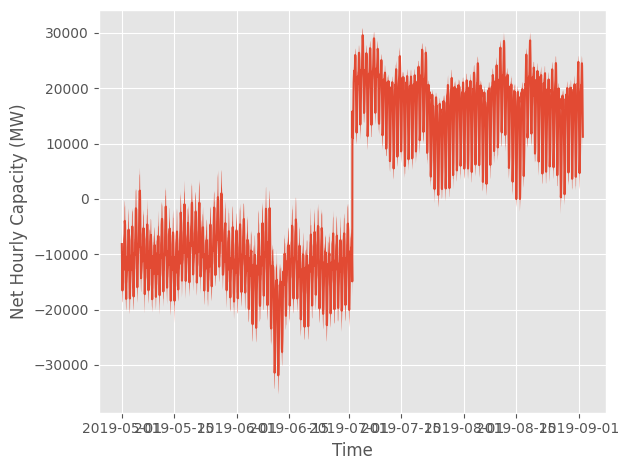

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 
min_net_hourly_capacity = simulation.net_hourly_capacity_matrix.mean(dim="trial")
mean_net_hourly_capacity = simulation.net_hourly_capacity_matrix.mean(dim="trial")
max_net_hourly_capacity = simulation.net_hourly_capacity_matrix.max(dim="trial")

fig, ax = plt.subplots()
ax.plot(median_50th_quantile.time, simulation.net_hourly_capaci)
ax.set_xlabel("Time")
ax.set_ylabel("Net Hourly Capacity (MW)")
plt.tight_layout()

### 4. Quantify resource adequacy

In [2]:
from assetra.metrics import ExpectedUnservedEnergy

# instantiate eue model
eue_model = ExpectedUnservedEnergy(simulation)

print("System EUE:", round(eue_model.evaluate(), 2),"MWh")


NameError: name 'simulation' is not defined

In [ ]:
from assetra.metrics import LossOfLoadHours, LossOfLoadDays, LossOfLoadFrequency

for name, metric in [
    ("EUE", ExpectedUnservedEnergy),
    ("LOLH", LossOfLoadHours),
    ("LOLD", LossOfLoadDays),
    ("LOLF", LossOfLoadFrequency)
]:
    summary[name] = metric(simulation).evaluate()

# show results
summary.round(1)

### 5. Quantify resource contribution (ELCC)

In [ ]:
from assetra.contribution import EffectiveLoadCarryingCapability

elcc = EffectiveLoadCarryingCapabitlity()

### 6. Appendix: CISO preprocessing

This example uses a number of external data sources providing historical demand, generator characteristics, and meteorology data. The following functions map specific data sources to the `assetra` compatible datasets used above. Specifically by:

1. Formatting datasets into time-indexed xarray data structures
2. Mapping generator locations to nearest available temperature or solar/wind capacity factor (CF) profiles
3. Mapping hourly temperature to hourly temperature-dependent forced outage rates.

**Table A1:** Data sources used for pre-processing.
| Source                                   | Primary Variables |
|------------------------------------------|-------------------|
| EIA-930/Ruggles et al.<sup>1</sup>       | hourly demand |
| EIA-860<sup>2</sup>                      | gen. nameplate capacity, <br> gen. latitude, <br> gen. longitude, <br> gen. technology, <br> storage energy capacity |
| MERRA/Bromley-Dulfano et al.<sup>3</sup> | hourly solar CF, <br> hourly wind CF, <br> hourly temperature|
| GADS/Murphy et al.<sup>4</sup>           | temperature-dependent generator outage rates (TDFOR) |

**Sources:**<br>
<sup>1</sup>https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data<br>
<sup>2</sup>https://www.eia.gov/electricity/data/eia860/<br>
<sup>3</sup>https://github.com/ijbd/merra-power-generation<br>
<sup>4</sup>https://www.sciencedirect.com/science/article/pii/S0306261919321117?via%3Dihub

We use the `EnergySystemBuilder` object to build the CISO energy system.

In [1]:
from assetra.system import EnergySystemBuilder

builder = EnergySystemBuilder()

# every unit must have a unique id
unit_count = 0

##### EIA-930

First, we create an `assetra.units.DemandUnit` from our historical hourly demand data.

In [2]:
from pathlib import Path
from datetime import datetime

import xarray as xr
import pandas as pd

def load_eia_930_cleaned_hourly_demand(
        eia_930_cleaned_demand_file: Path,
        start_hour: datetime,
        end_hour: datetime) -> xr.DataArray:
    """Return hourly demand data as formatted data array.
    To use this function, download cleaned demand data from:

    https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data

    Args:
        eia_930_cleaned_demand_file (Path): Path to hourly demand file
        start_hour (datetime): First timestamp to include
        end_hour (datetime): Last timestamp to include (inclusive)

    Returns:
        xr.DataArray: Hourly demand array with time dimension and datetime coordinates.
    """
    # read demand file
    eia_930_df = pd.read_csv(
        eia_930_cleaned_demand_file,
        usecols=["date_time", "cleaned demand (MW)"],
        index_col="date_time",
        parse_dates=True,
    )

    # keep cleaned demand demand
    eia_930_hourly_demand_pd = eia_930_df["cleaned demand (MW)"].loc[start_hour:end_hour]

    # convert to xr.DataArray
    eia_930_hourly_demand = xr.DataArray(
        data=eia_930_hourly_demand_pd.values,
        coords=dict(
            time=eia_930_hourly_demand_pd.index.values
        )
    )
    return eia_930_hourly_demand


In [3]:

# load demand data
eia_930_cleaned_demand_file = Path('sample_data', 'CISO.csv')
hourly_demand = load_eia_930_cleaned_hourly_demand(
	eia_930_cleaned_demand_file,
	start_hour='2019-01-01 00:00:00',
	end_hour='2019-12-31 23:00:00'
)

# create demand unit
from assetra.units import DemandUnit

builder.add_unit(
    DemandUnit(
        id=unit_count,
        hourly_demand=hourly_demand
    )
)
unit_count += 1

##### EIA-860


We gather generating unit information from EIA Form 860. EIA-860 data is stored in multiple files at both the plant and unit level. We filter the plant-level dataset to only include our balancing authority of interest (CISO).

In [4]:
def load_eia_860_plants(eia_860_plant_file: Path, bal_auth: str) -> pd.DataFrame:
    """Return a subset of the EIA 860 plant file for plants in a balancing authority

    Args:
        eia_860_plant_file (Path): Path to hourly demand file
        bal_auth (str): Balancing authority code as defined by EIA-860

    Returns:
        pd.DataFrame: Plant code-indexed dataframe with plant latitude and longitude
    """
    # read file
    eia_860_plant_df = pd.read_excel(
        eia_860_plant_file,
        skiprows=1,
        usecols=[
            "Plant Code",
            "Latitude",
            "Longitude",
            "Balancing Authority Code",
        ],
        index_col="Plant Code",
    )

    # filter
    eia_860_plant_df = eia_860_plant_df[
        eia_860_plant_df["Balancing Authority Code"] == bal_auth
    ]

    return eia_860_plant_df


In [5]:

# parse eia 860 plants (selecting by balancing authority)
eia_860_plant_file = Path('sample_data', '2___Plant_Y2019.xlsx')
eia_860_plants = load_eia_860_plants(eia_860_plant_file, 'CISO')

We aggregate generators into four different categories for pre-processing: solar, wind, storage, and thermal. For this example, thermal generators include any units not fitting into the three former categories (e.g. hydroelectric is characterized as a thermal unit). 

In [6]:
def load_eia_860_generators(
    eia_860_generator_file: Path,
    eia_860_plants: pd.DataFrame,
    additional_cols: list=[],
    tech_filter: list=[],
    invert_tech_filter: bool=False
    ) -> pd.DataFrame:
    """Return dataframe with generators' latitude, longitude, technology, and nameplate capacity"""
    # read file
    eia_860_generator_df = pd.read_excel(
        eia_860_generator_file,
        skiprows=1,
        usecols=[
            "Plant Code",
            "Technology",
            "Nameplate Capacity (MW)",
            "Status"
        ] + additional_cols,
    )

    # filter by plants
    eia_860_generator_df = eia_860_generator_df[
        eia_860_generator_df["Plant Code"].isin(eia_860_plants.index)
    ]

    # filter by technology
    if tech_filter:
        if invert_tech_filter:
            eia_860_generator_df = eia_860_generator_df[
                ~eia_860_generator_df["Technology"].isin(
                    tech_filter
                )
            ]
        else:
            eia_860_generator_df = eia_860_generator_df[
                eia_860_generator_df["Technology"].isin(
                    tech_filter
                )
            ]

    # filter by status
    eia_860_generator_df = eia_860_generator_df[
        eia_860_generator_df["Status"] == "OP"
    ]

    eia_860_generator_df["Latitude"] = eia_860_generator_df["Plant Code"].map(lambda plant_code: eia_860_plants["Latitude"][plant_code])
    eia_860_generator_df["Longitude"] = eia_860_generator_df["Plant Code"].map(lambda plant_code: eia_860_plants["Longitude"][plant_code])

    return eia_860_generator_df

In [7]:

# parse eia 860 generator types
EIA_860_NON_THERMAL_TECHNOLOGY = [
    "Onshore Wind Turbine",
    #"Conventional Hydroelectric",
    "Solar Photovoltaic",
    "Offshore Wind Turbine",
    "Batteries",
    "Hydroelectric Pumped Storage"
]
eia_860_generator_file = Path('sample_data', '3_1_Generator_Y2019.xlsx')
eia_860_wind_file = Path('sample_data', '3_2_Wind_Y2019.xlsx')
eia_860_solar_file = Path('sample_data', '3_3_Solar_Y2019.xlsx')
eia_860_storage_file = Path('sample_data', '3_4_Energy_Storage_Y2019.xlsx')

eia_860_thermal_generators = load_eia_860_generators(
    eia_860_generator_file, 
    eia_860_plants,
    tech_filter=EIA_860_NON_THERMAL_TECHNOLOGY,
    invert_tech_filter=True
)
eia_860_wind_generators = load_eia_860_generators(
    eia_860_wind_file,
    eia_860_plants
)
eia_860_solar_generators = load_eia_860_generators(
    eia_860_solar_file,
    eia_860_plants
)
eia_860_storage_generators = load_eia_860_generators(
    eia_860_storage_file,
    eia_860_plants,
    additional_cols=["Nameplate Energy Capacity (MWh)"]
)

##### MERRA Power Generation

We need additional information to create hourly capacity and hourly forced outage profiles. We gather solar and wind capacity factors and temperature data from the MERRA power generation repository (see Appendix Table A1), and we use a look-up table holding temperature-dependent forced outage rates for different technology categories.

In [16]:
# load processed power generation dataset (solar cf, wind cf, and temperature)
pow_gen_file = Path('sample_data','merra_power_generation_ciso_2019.nc')
pow_gen_dataset = xr.open_dataset(pow_gen_file)

def get_nearest_hourly_profile(
    latitude: float,
    longitude: float,
    array: xr.DataArray
) -> xr.DataArray:
    """Return time series corresponding to the nearest coordinate in a
    MERRA power generation data array.

    Args:
        latitude (float): Latitude relative to equator in degrees
        start_hour (datetime): Longitude relative to meridian in degrees
        array (xr.DataArray): 'solar_capacity_factor', 'wind_capacity_factor',
            or 'temperature'

    Returns:
        xr.DataArray: Array with time dimension and datetime coordinates.
    """
    return array.sel(
            lat=latitude, 
            lon=longitude, 
            method='nearest'
        ).squeeze(drop=True)

def get_merra_power_generation_solar_cf(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset['solar_capacity_factor'])

def get_merra_power_generation_wind_cf(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset['wind_capacity_factor'])

def get_merra_power_generation_temperature(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset['temperature'])

In [9]:

# load temperature dependent outage rate (tdfor) table
tdfor_table_file = Path('sample_data', 'temperature_dependent_outage_rates.csv')
tdfor_table = pd.read_csv(tdfor_table_file, index_col=0)
tdfor_table = tdfor_table / 100 # percentages stored as integers

# create mapping table for tdfor table
tech_categories = {
    "CC" : ["Natural Gas Fired Combined Cycle"],
    "CT" : ["Natural Gas Fired Combustion Turbine","Landfill Gas"],
    "DS" : ["Natural Gas Internal Combustion Engine"],
    "ST" : ["Conventional Steam Coal","Natural Gas Steam Turbine"],
    "NU" : ["Nuclear"],
    "HD" : ["Conventional Hydroelectric","Solar Thermal without Energy Storage",
                   "Hydroelectric Pumped Storage","Solar Thermal with Energy Storage","Wood/Wood Waste Biomass"]
}

# create mapping from technology to category
tech_mapping = {tech : cat for cat, techs in tech_categories.items() for tech in techs}

def get_hourly_forced_outage_rate(hourly_temperature: xr.DataArray, technology: str) -> xr.DataArray:
    # index tdfor table by tech
    tdfor_map = tdfor_table[tech_mapping.get(technology, 'Other')]
    map_temp_to_for = lambda hourly_temperature: tdfor_map.iloc[
            tdfor_map.index.get_indexer(hourly_temperature, method="nearest")
        ]
    return xr.apply_ufunc(
        map_temp_to_for,
        hourly_temperature
    ).rename("hourly_forced_outage_rate")

##### Build Units

For conventional thermal generators, we map hourly temperature profiles into temperature-dependent forced outage rates, then instantiate thermal units as `assetra.units.StochasticUnit` objects. 

In [10]:
from assetra.units import StochasticUnit

for _, generator in eia_860_thermal_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["Latitude"],
        generator["Longitude"]
    )

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # get hourly capacity
    hourly_capacity = ( 
        xr.ones_like(hourly_temperature).rename('hourly_capacity') 
        * generator['Nameplate Capacity (MW)']
    )

    # create assetra energy unit
    thermal_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator['Nameplate Capacity (MW)'],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate
        )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(thermal_unit)

For solar and wind generators, we additionally scale nameplate capacities by hourly capacity factors from our MERRA power generation dataset. Solar and wind generators are added as `assetra.units.StochasticUnit` objects.


In [17]:
from assetra.units import StochasticUnit

# add solar
for _, generator in eia_860_solar_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["Latitude"],
        generator["Longitude"]
    )
    # get hourly temperature
    hourly_capacity = get_merra_power_generation_solar_cf(
        generator["Latitude"],
        generator["Longitude"]
    ) * generator["Nameplate Capacity (MW)"]

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # create assetra energy unit
    solar_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator['Nameplate Capacity (MW)'],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate
        )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(solar_unit)

# add wind
for _, generator in eia_860_wind_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["Latitude"],
        generator["Longitude"]
    )
    # get hourly temperature
    hourly_capacity = get_merra_power_generation_wind_cf(
        generator["Latitude"],
        generator["Longitude"]
    ) * generator["Nameplate Capacity (MW)"]

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # create assetra energy unit
    wind_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate
        )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(wind_unit)

Lastly, we add storage units as `assetra.units.StorageUnit` objects.

In [18]:
from assetra.units import StorageUnit

STORAGE_EFFICIENCY = 0.8

for _, generator in eia_860_storage_generators.iterrows():
    storage_unit = StorageUnit(
        id=unit_count,
        nameplate_capacity=generator["Nameplate Capacity (MW)"],
        charge_rate=generator["Nameplate Capacity (MW)"],
        discharge_rate=generator["Nameplate Capacity (MW)"],
        charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
        roundtrip_efficiency=STORAGE_EFFICIENCY
    )
    unit_count += 1

    # add unit to energy system
    builder.add_unit(storage_unit)


Now that we have added all of our units, we can build and save our energy system.

In [24]:
energy_system = builder.build()
energy_system.save(ciso_system_dir)